# Entwicklung von KI in der Wissenschaft

In [493]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import make_interp_spline
from sklearn.linear_model import HuberRegressor

## Helper Functions

In [494]:
def plot_with_spline(df, title, period):
    df["period"] = df["published_date"].dt.to_period(period)
    papers_per_period = df.groupby("period").size().reset_index(name="count")
    papers_per_period["period"] = papers_per_period["period"].dt.to_timestamp()

    # Convert datetime to numeric for spline fitting
    x = (
        papers_per_period["period"].astype("int64")
    )  # Convert to seconds since epoch
    y = papers_per_period["count"]

    # Fit a smooth spline
    spline = make_interp_spline(x, y, k=3)  # k=3 for cubic spline
    x_smooth = np.linspace(x.min(), x.max(), 7)
    y_smooth = spline(x_smooth)

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

    # Scatter plot on the first chart
    sns.scatterplot(data=papers_per_period, x="period", y="count", ax=ax1, label="Data")
    ax1.plot(
        pd.to_datetime(x_smooth, unit="ns"),
        y_smooth,
        color="red",
        linewidth=3,  # Make line thicker
        label="Smooth Line (Spline)",
    )
    ax1.set_xlabel("Period")
    ax1.set_ylabel("Number of Papers")
    ax1.set_title(title + " (Original Scale)")
    ax1.legend()

    # Scatter plot on the second chart with logarithmic scale
    sns.scatterplot(data=papers_per_period, x="period", y="count", ax=ax2, label="Data")
    ax2.plot(
        pd.to_datetime(x_smooth, unit="ns"),
        y_smooth,
        color="red",
        linewidth=3,  # Make line thicker
        label="Smooth Line (Spline)",
    )
    ax2.set_yscale('log')
    ax2.set_xlabel("Period")
    ax2.set_ylabel("Number of Papers (Log Scale)")
    ax2.set_title(title + " (Logarithmic Scale)")
    ax2.legend()

    plt.tight_layout()
    plt.show()

## Data

In [495]:
df = pd.read_csv("arxiv_papers.csv")
df.head()

,paper_id,published_date,categories,id
0,http://arxiv.org/abs/cs/9401101v1,1994-01-01,cs.AI,9401101v1
1,http://arxiv.org/abs/cs/9403101v1,1994-03-01,cs.AI,9403101v1
2,http://arxiv.org/abs/cs/9402101v1,1994-02-01,cs.AI,9402101v1
3,http://arxiv.org/abs/cs/9402102v1,1994-02-01,cs.AI,9402102v1
4,http://arxiv.org/abs/cs/9402103v1,1994-02-01,cs.AI,9402103v1


These categories can be used in search queries to filter relevant papers.

- cs.LG: Machine Learning
- cs.AI: Artificial Intelligence
- stat.ML: Statistics > Machine Learning
- cs.NE: Neural and Evolutionary Computing
- cs.CL: Computation and Language
- cs.CV: Computer Vision and Pattern Recognition
- cs.RO: Robotics

In [496]:
df["published_date"] = pd.to_datetime(df["published_date"])

# df = df[df["published_date"] < "2022-01-01"]

categories = ["cs.lg", "cs.ai", "stat.ml", "cs.ne", "cs.cl", "cs.cv", "cs.ro"]
df = df[df["categories"].str.lower().str.contains('|'.join(categories))]

## Visualization

### Allgemeine Entwicklung

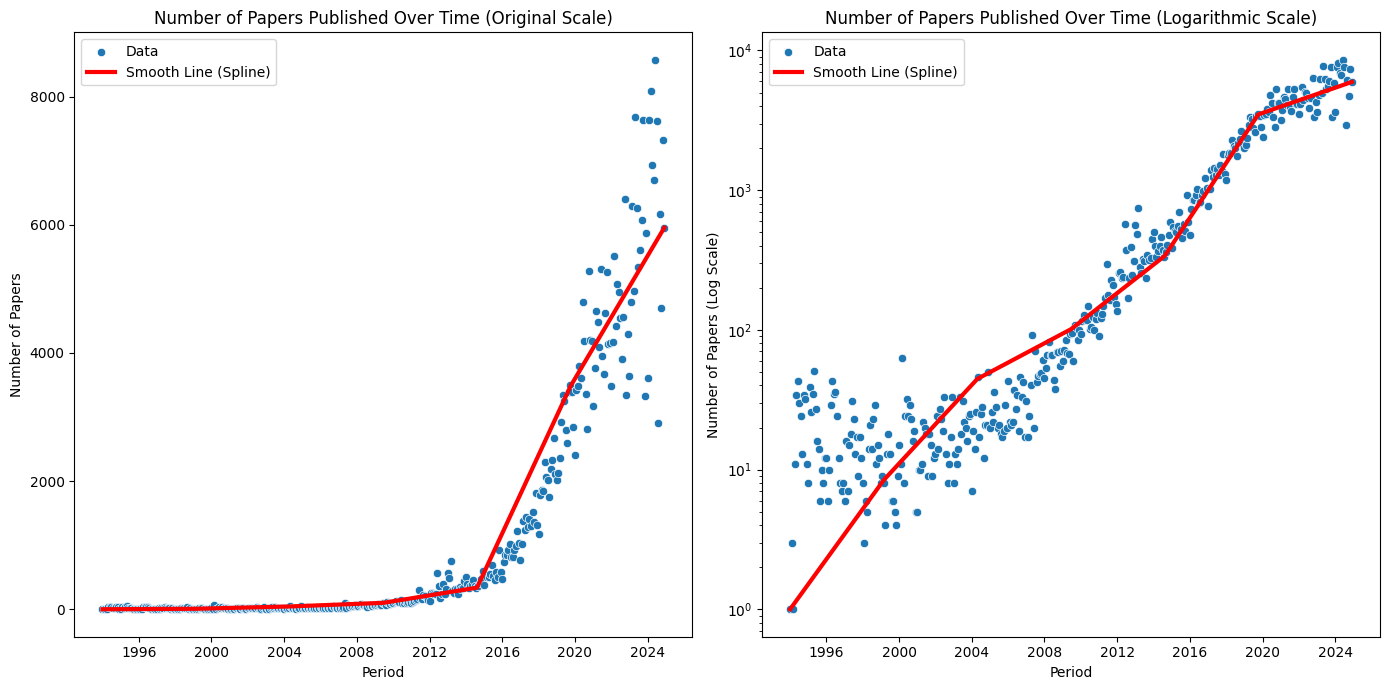

In [497]:
df = df[df["categories"].str.lower().str.contains('|'.join(categories))]
plot_with_spline(df, "Number of Papers Published Over Time", "M")

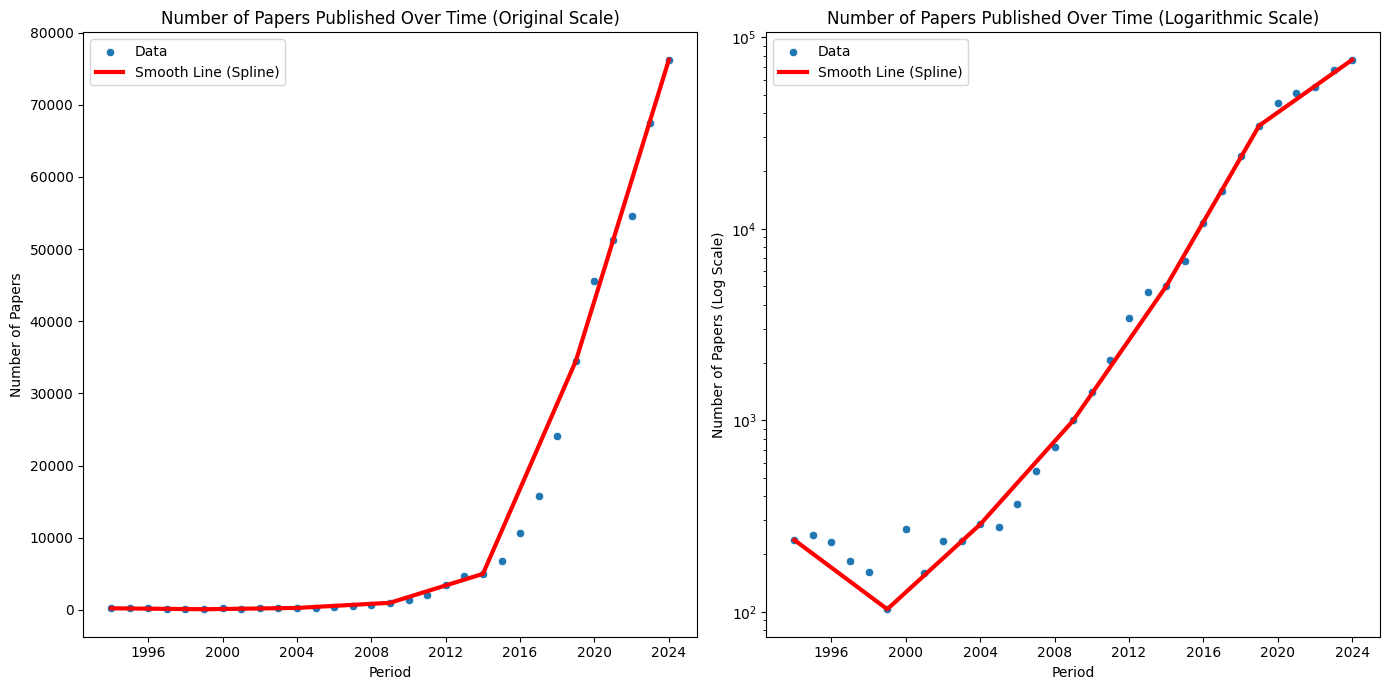

In [498]:
plot_with_spline(df, "Number of Papers Published Over Time", "Y")

### Nach Kategorien

### Nach 5-Jahres Perioden

In [499]:
period = 5 # in years
df["published_date"] = pd.to_datetime(df["published_date"])
df["period"] = (df["published_date"].dt.year // period) * period
df["period"] = df["period"].astype(str) + " - " + (df["period"] + period - 1).astype(str)
df

,paper_id,published_date,categories,id,period
0,http://arxiv.org/abs/cs/9401101v1,1994-01-01,cs.AI,9401101v1,1990 - 1994
1,http://arxiv.org/abs/cs/9403101v1,1994-03-01,cs.AI,9403101v1,1990 - 1994
2,http://arxiv.org/abs/cs/9402101v1,1994-02-01,cs.AI,9402101v1,1990 - 1994
3,http://arxiv.org/abs/cs/9402102v1,1994-02-01,cs.AI,9402102v1,1990 - 1994
4,http://arxiv.org/abs/cs/9402103v1,1994-02-01,cs.AI,9402103v1,1990 - 1994
...,...,...,...,...,...
408813,http://arxiv.org/abs/2412.04683v1,2024-12-06,cs.AI,2412.04683v1,2020 - 2024
408814,http://arxiv.org/abs/2412.04682v1,2024-12-06,"cs.LG,cs.AI",2412.04682v1,2020 - 2024
408815,http://arxiv.org/abs/2412.04680v1,2024-12-06,cs.CV,2412.04680v1,2020 - 2024
408816,http://arxiv.org/abs/2412.04678v1,2024-12-06,cs.CV,2412.04678v1,2020 - 2024


period,1990 - 1994,1995 - 1999,2000 - 2004,2005 - 2009,2010 - 2014,2015 - 2019,2020 - 2024
categories,,,,,,,
cs.ai,14,81,9,228,2362,2290,4859
cs.cl,0,0,6,98,457,6251,18497
cs.cv,0,0,1,114,1691,17952,41727
cs.lg,0,0,0,117,674,1706,15511
cs.ne,0,0,0,80,331,842,1213
cs.ro,0,0,12,158,319,2697,9988
stat.ml,0,0,0,75,419,978,23


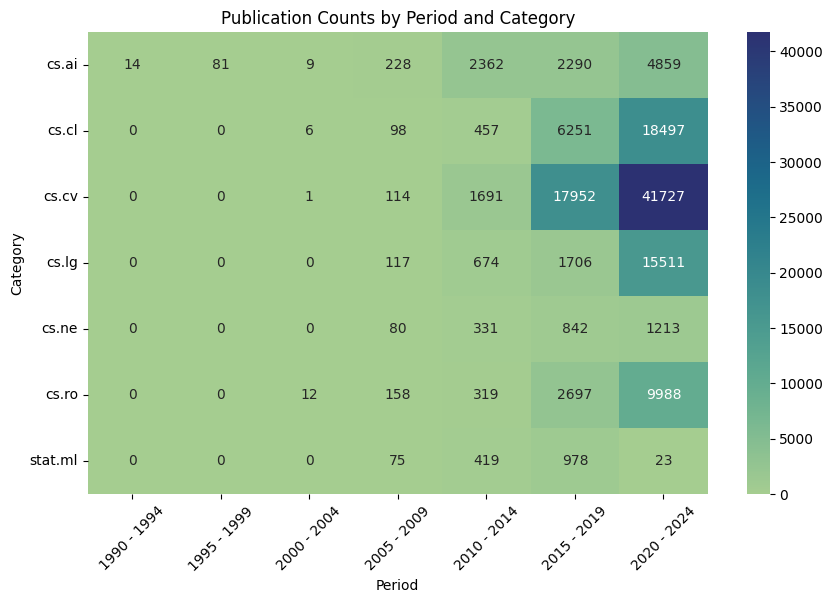

In [500]:
# Explode the categories column to handle multiple categories per paper.
df['categories'] = df['categories'].str.lower().str.split(';')
df = df.explode('categories')
df['categories'] = df['categories'].str.strip()

# Filter for the categories of interest
df_filtered = df[df['categories'].isin(categories)]

# Create the counts table
counts = df_filtered.groupby(['categories', "period"]).size().unstack(fill_value=0)
display(counts)

# Plot the heatmap
plt.figure(figsize=(10, 6))  # Adjust figure size for better readability
sns.heatmap(counts, annot=True, fmt="d", cmap="crest")  # Added annotations and colormap
plt.title("Publication Counts by Period and Category")
plt.xlabel("Period")
plt.xticks(rotation=45)  # Rotate x ticks for better readability
plt.ylabel("Category")
plt.yticks(rotation=0) #prevent rotation of y ticks
plt.show()

### Nach Jahr

In [501]:
period = 1 # in years
df["period"] = df["published_date"].dt.year
df

,paper_id,published_date,categories,id,period
0,http://arxiv.org/abs/cs/9401101v1,1994-01-01,cs.ai,9401101v1,1994
1,http://arxiv.org/abs/cs/9403101v1,1994-03-01,cs.ai,9403101v1,1994
2,http://arxiv.org/abs/cs/9402101v1,1994-02-01,cs.ai,9402101v1,1994
3,http://arxiv.org/abs/cs/9402102v1,1994-02-01,cs.ai,9402102v1,1994
4,http://arxiv.org/abs/cs/9402103v1,1994-02-01,cs.ai,9402103v1,1994
...,...,...,...,...,...
408813,http://arxiv.org/abs/2412.04683v1,2024-12-06,cs.ai,2412.04683v1,2024
408814,http://arxiv.org/abs/2412.04682v1,2024-12-06,"cs.lg,cs.ai",2412.04682v1,2024
408815,http://arxiv.org/abs/2412.04680v1,2024-12-06,cs.cv,2412.04680v1,2024
408816,http://arxiv.org/abs/2412.04678v1,2024-12-06,cs.cv,2412.04678v1,2024


period,1994,1995,1996,1997,1998,2004,2005,2006,2007,2008,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
categories,,,,,,,,,,,,,,,,,,,,,
cs.ai,14,26,28,18,9,9,18,32,41,56,...,279,337,549,662,463,652,842,738,1130,1497
cs.cl,0,0,0,0,0,6,4,11,25,18,...,275,744,1227,1880,2125,2644,3239,3244,4182,5188
cs.cv,0,0,0,0,0,1,7,13,19,26,...,1320,2278,3728,5396,5230,5832,7021,7742,10125,11007
cs.lg,0,0,0,0,0,0,6,17,17,30,...,365,447,599,188,107,779,3372,3523,3816,4021
cs.ne,0,0,0,0,0,0,12,8,18,23,...,104,105,175,252,206,235,212,249,230,287
cs.ro,0,0,0,0,0,12,4,21,83,19,...,133,299,547,778,940,1132,1595,1819,2501,2941
stat.ml,0,0,0,0,0,0,0,0,11,22,...,229,264,394,90,1,1,2,3,16,1


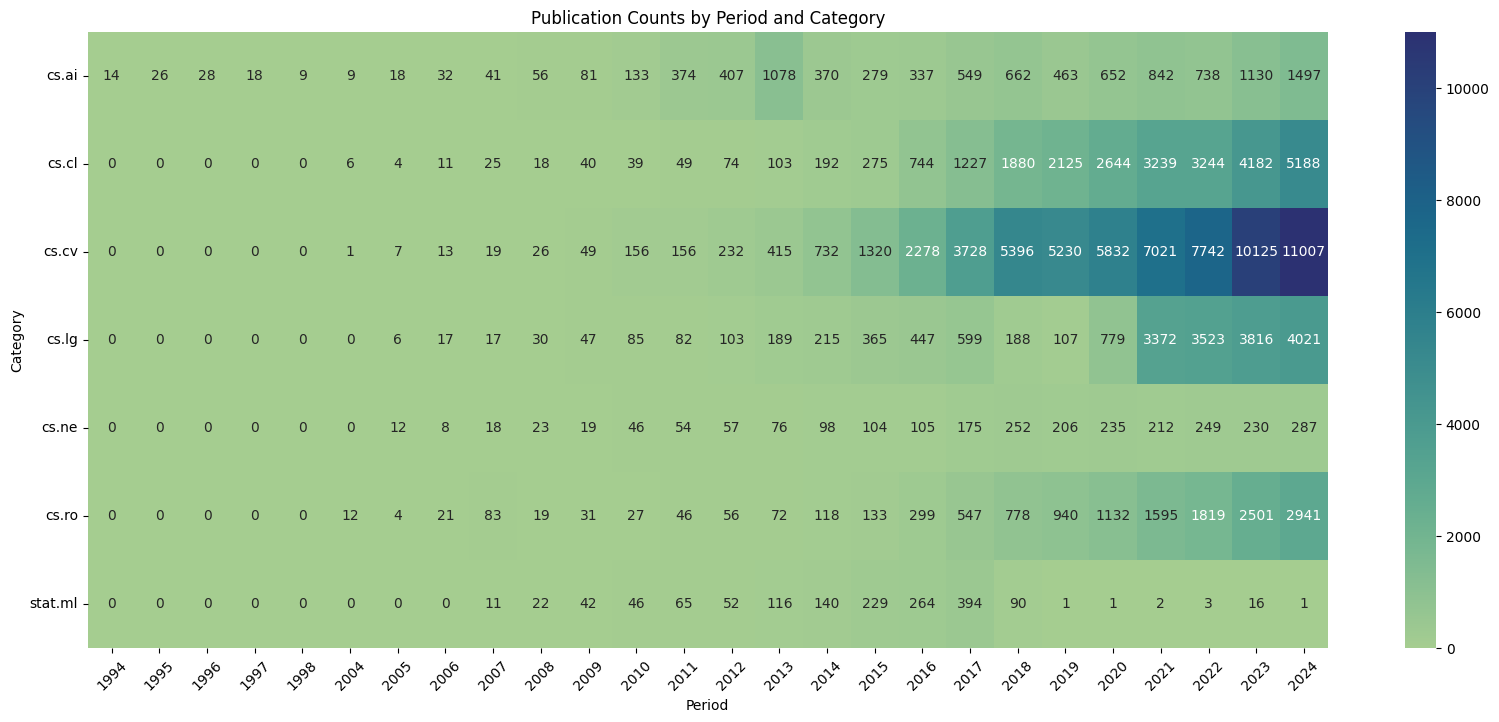

In [502]:
# Explode the categories column to handle multiple categories per paper.
df['categories'] = df['categories'].str.lower().str.split(';')
df = df.explode('categories')
df['categories'] = df['categories'].str.strip()

# Filter for the categories of interest
df_filtered = df[df['categories'].isin(categories)]

# Create the counts table
counts = df_filtered.groupby(['categories', "period"]).size().unstack(fill_value=0)
display(counts)

# Plot the heatmap
plt.figure(figsize=(20, 8))  # Adjust figure size for better readability
sns.heatmap(counts, annot=True, fmt="d", cmap="crest")  # Added annotations and colormap
plt.title("Publication Counts by Period and Category")
plt.xlabel("Period")
plt.xticks(rotation=45)  # Rotate x ticks for better readability
plt.ylabel("Category")
plt.yticks(rotation=0) #prevent rotation of y ticks
plt.show()

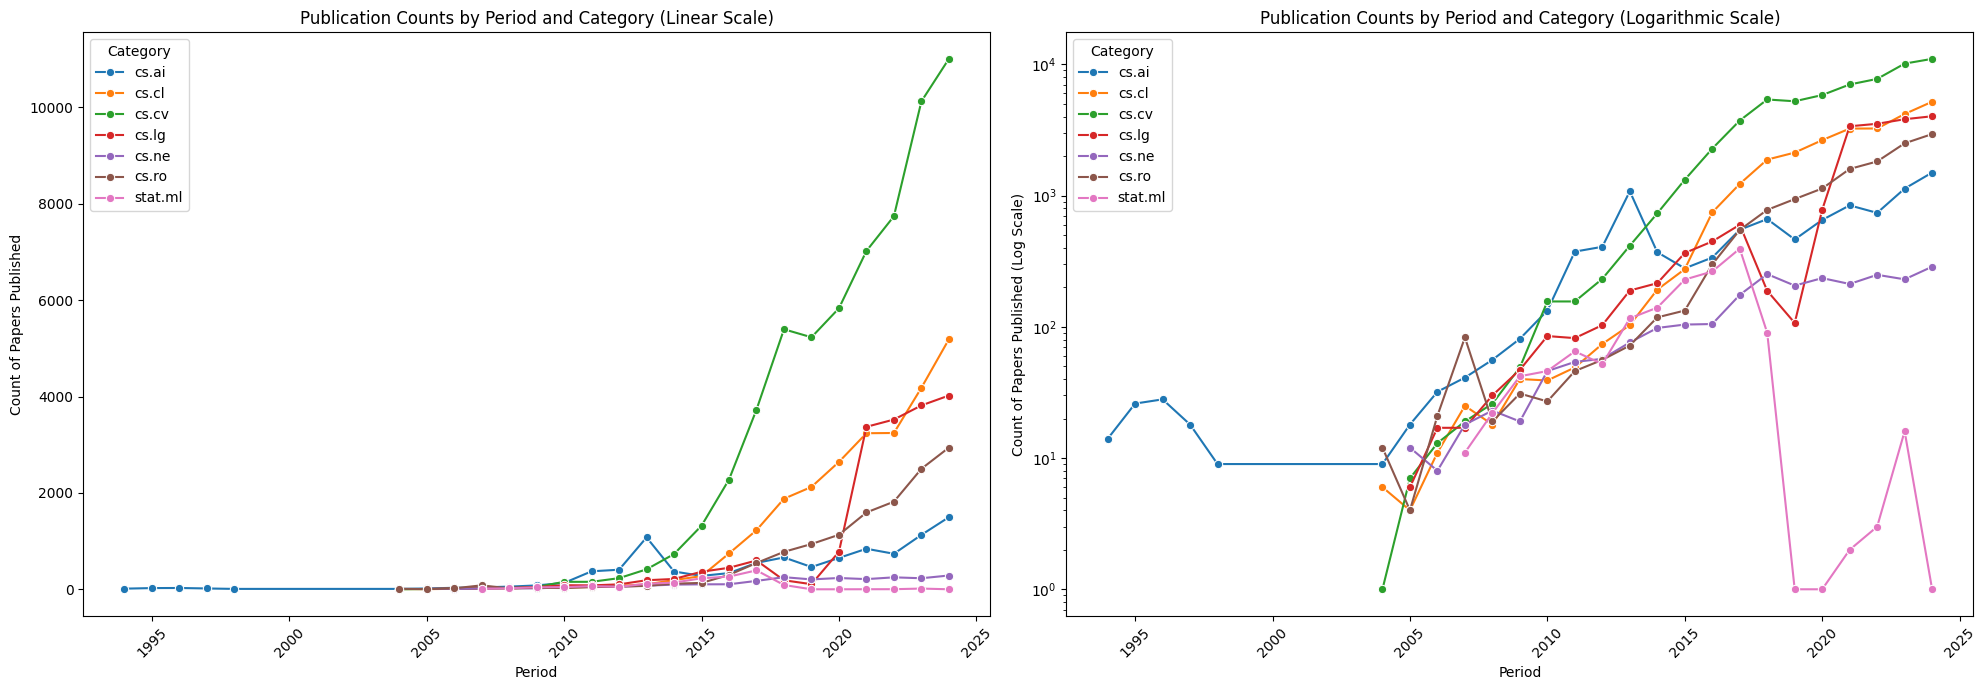

In [503]:
# Explode the categories column to handle multiple categories per paper.
df['categories'] = df['categories'].str.lower().str.split(';')
df = df.explode('categories')
df['categories'] = df['categories'].str.strip()

# Filter for the categories of interest
df_filtered = df[df['categories'].isin(categories)]

# Create the counts table
counts = df_filtered.groupby(['categories', "period"]).size().reset_index(name='count')

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# Plot the line chart with linear scale
sns.lineplot(data=counts, x='period', y='count', hue='categories', marker='o', ax=ax1)
ax1.set_title("Publication Counts by Period and Category (Linear Scale)")
ax1.set_xlabel("Period")
ax1.set_ylabel("Count of Papers Published")
ax1.legend(title='Category')
ax1.tick_params(axis='x', rotation=45)

# Plot the line chart with logarithmic scale
sns.lineplot(data=counts, x='period', y='count', hue='categories', marker='o', ax=ax2)
ax2.set_yscale('log')
ax2.set_title("Publication Counts by Period and Category (Logarithmic Scale)")
ax2.set_xlabel("Period")
ax2.set_ylabel("Count of Papers Published (Log Scale)")
ax2.legend(title='Category')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()